In [25]:
!bash ex1.sh

/venv/env1/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:29<00:00,  9.77s/it]
Some weights of LlavaForConditionalGenerationScal were not initialized from the model checkpoint at llava-hf/llava-1.5-7b-hf and are newly initialized: ['language_model.model.layers.0.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.1.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.10.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.11.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.12.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.13.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.14.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.15.self

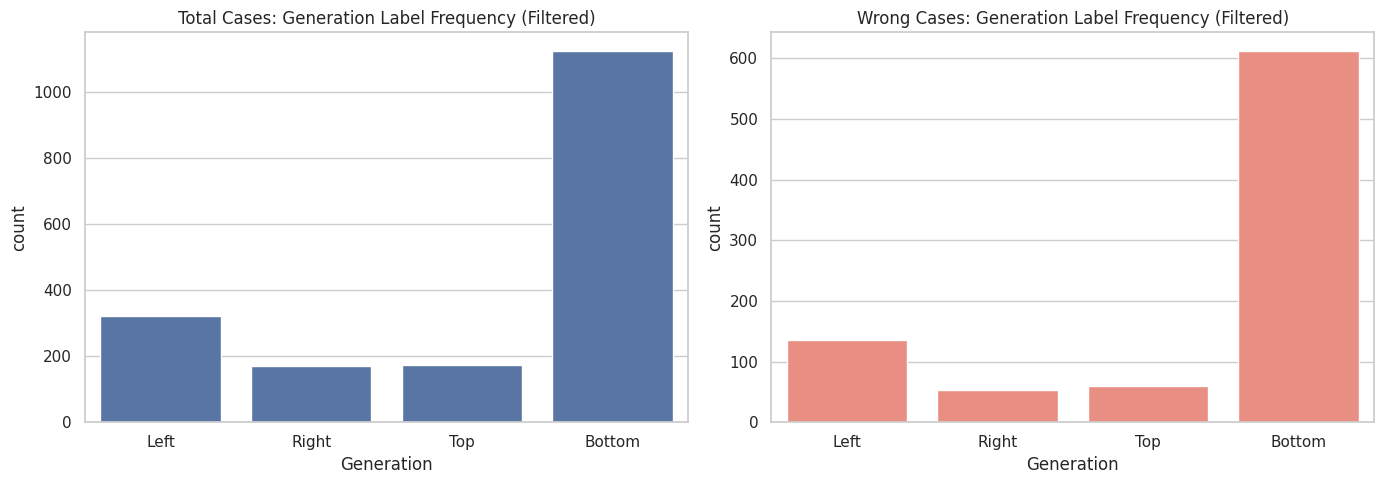

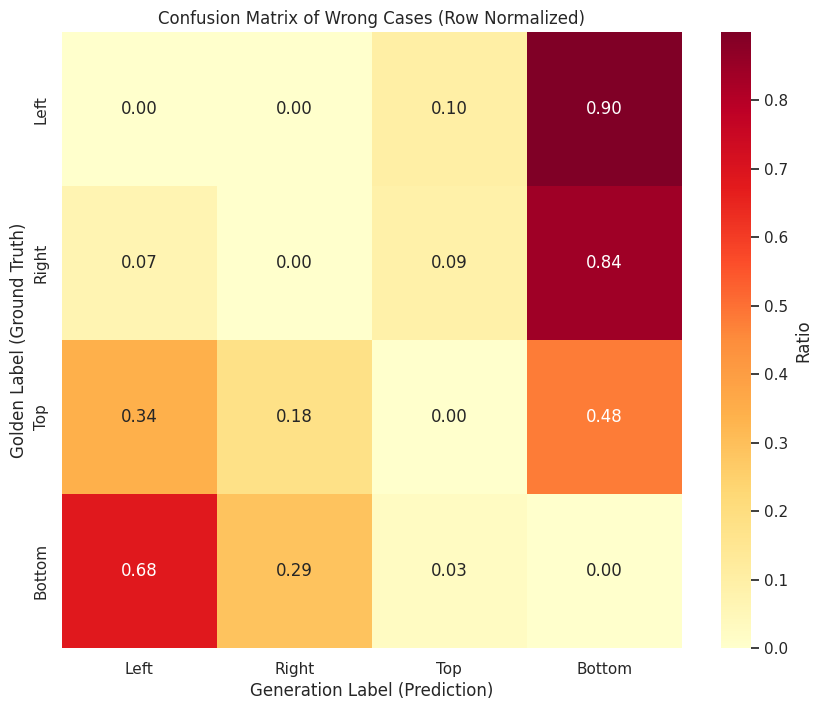

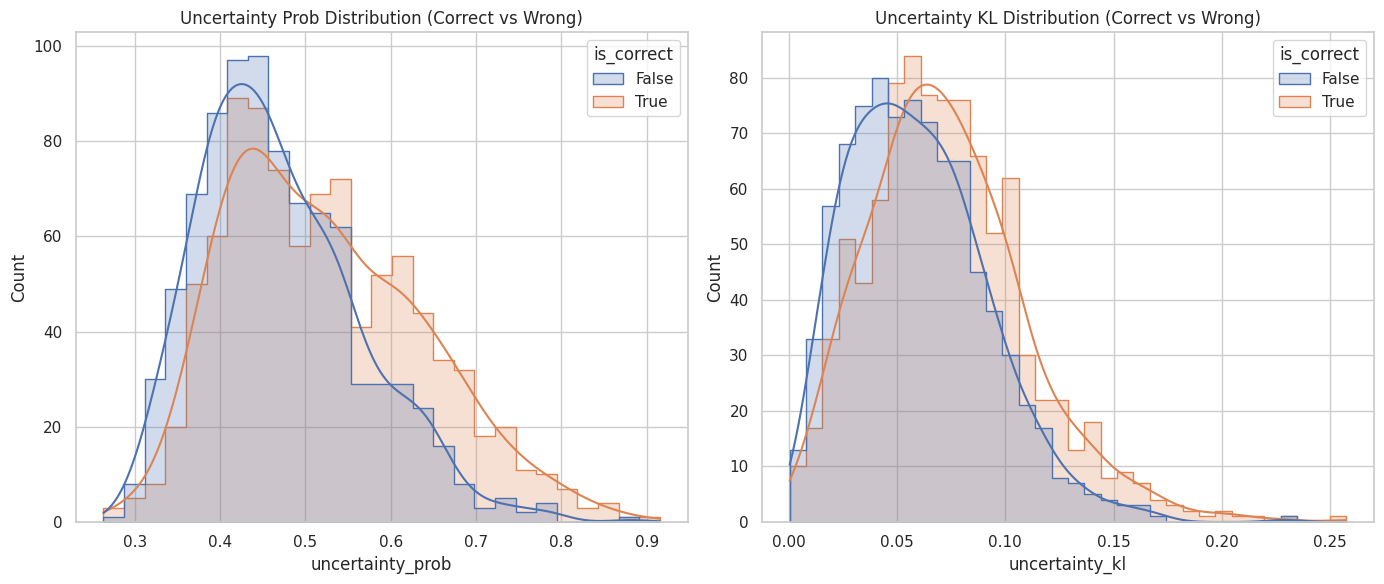

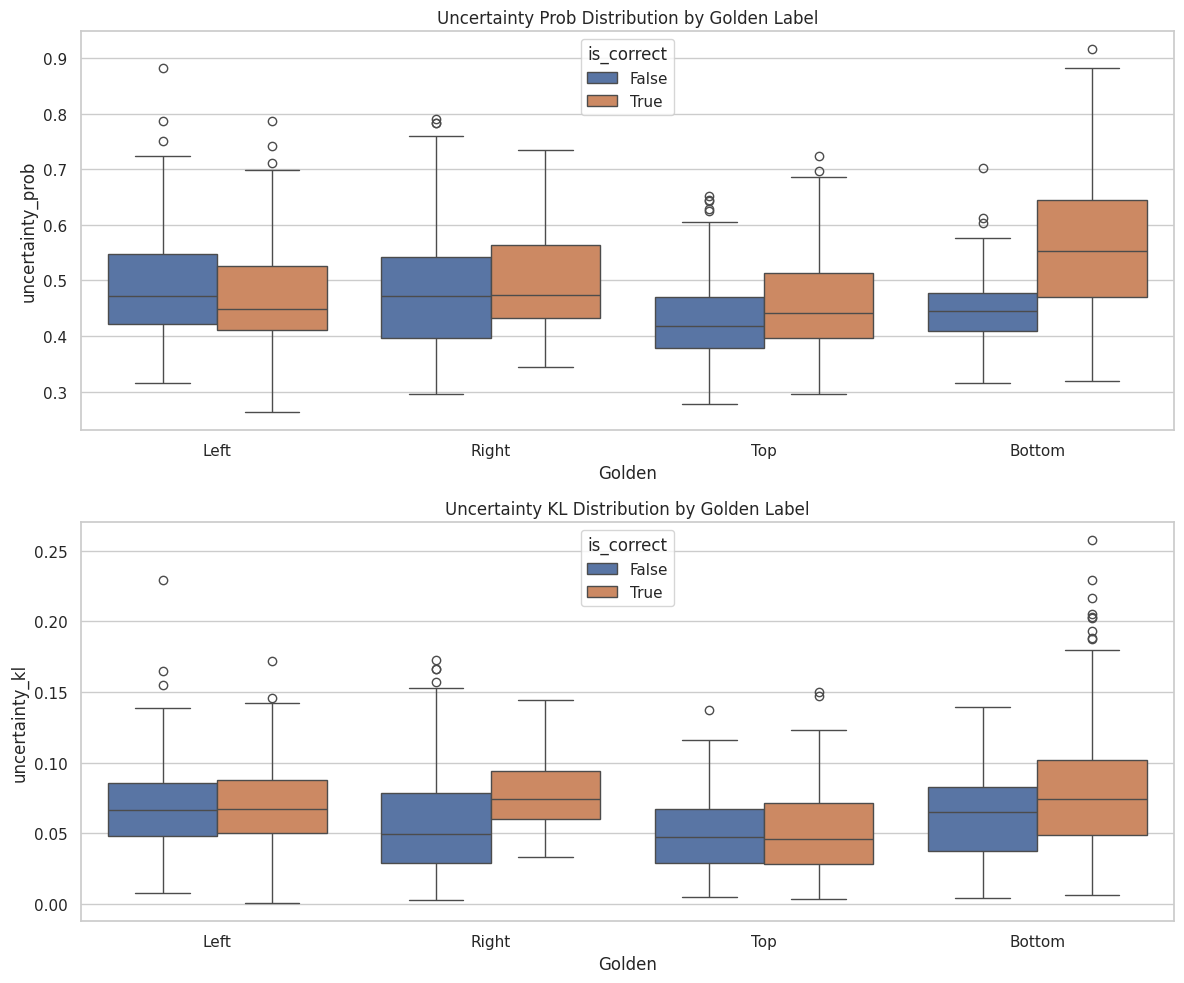

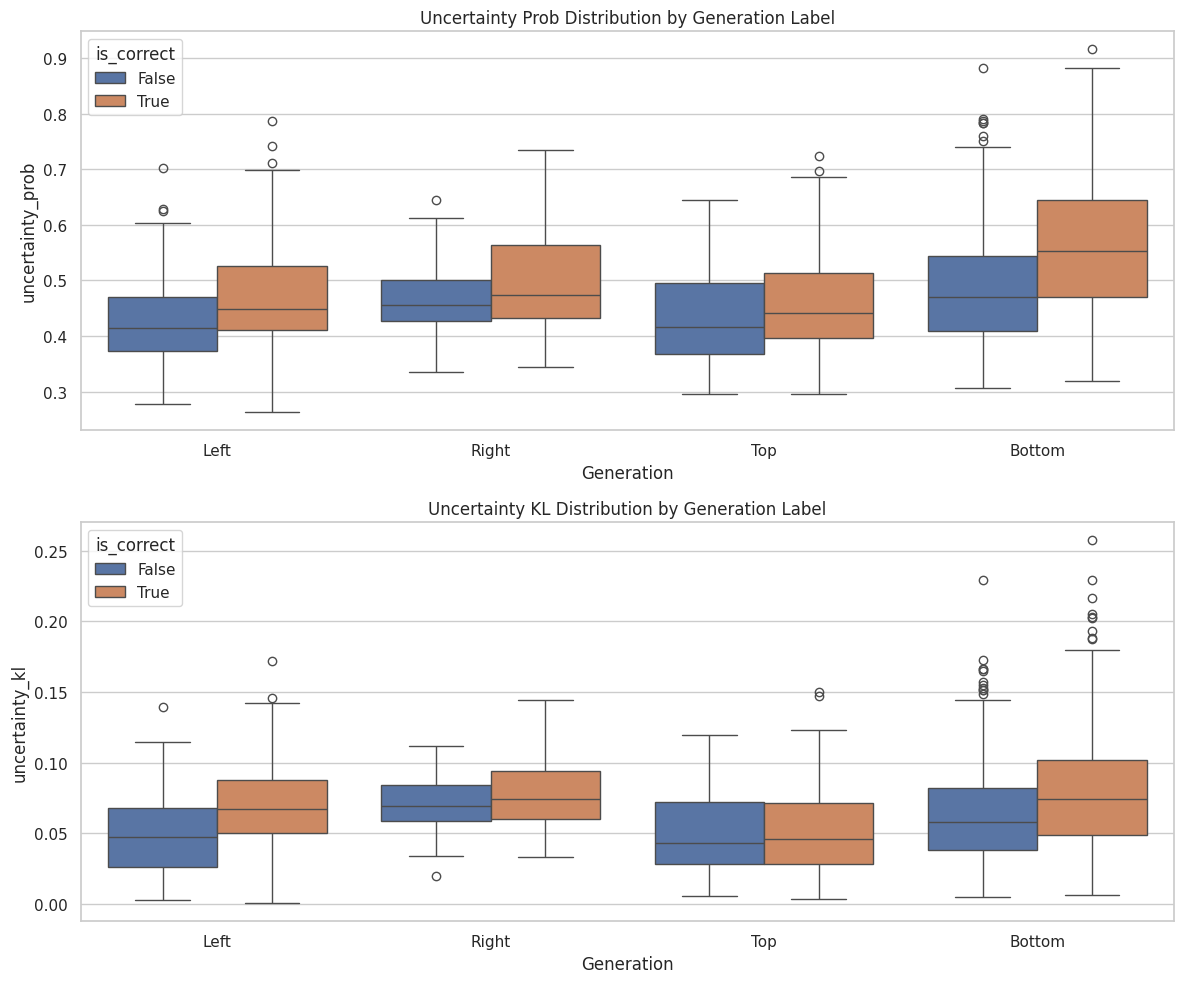

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
path = "output/results1.5_COCO_QA_one_obj_adapt_vis_5_1.0_0.05_fouroption_True.json"
with open(path, 'r') as f:
    json_data = json.load(f)
df = pd.DataFrame(json_data)

# 2. Data Filtering & Pre-processing
# Define valid labels
valid_labels = ['Left', 'Right', 'Top', 'Bottom']

# Normalize to Title Case just in case (e.g., "left" -> "Left")
df['Generation'] = df['Generation'].str.title()
df['Golden'] = df['Golden'].str.title()

# Filter: Keep only rows where Generation is one of the valid labels
df = df[df['Generation'].isin(valid_labels)].copy()

# Re-calculate correctness after filtering
df['is_correct'] = df['Generation'] == df['Golden']
wrong_df = df[~df['is_correct']]
correct_df = df[df['is_correct']]

# Visualization Settings
sns.set_theme(style="whitegrid")

# ==============================================================================
# Analysis 1: Generation label frequency / Wrong case generation label frequency
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Explicit order for consistency
label_order = valid_labels

sns.countplot(data=df, x='Generation', ax=axes[0], order=label_order)
axes[0].set_title('Total Cases: Generation Label Frequency (Filtered)')

sns.countplot(data=wrong_df, x='Generation', ax=axes[1], order=label_order, color='salmon')
axes[1].set_title('Wrong Cases: Generation Label Frequency (Filtered)')

plt.tight_layout()
plt.show()

# ==============================================================================
# Analysis 2: Ratio of Generation label to Golden label in Wrong cases
# ==============================================================================
# Crosstab (Row Normalized)
confusion_ratio = pd.crosstab(wrong_df['Golden'], wrong_df['Generation'], normalize='index')

# Reindex to ensure all 4 labels appear even if count is 0
confusion_ratio = confusion_ratio.reindex(index=valid_labels, columns=valid_labels, fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_ratio, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Ratio'})
plt.title('Confusion Matrix of Wrong Cases (Row Normalized)')
plt.ylabel('Golden Label (Ground Truth)')
plt.xlabel('Generation Label (Prediction)')
plt.show()

# ==============================================================================
# Analysis 3 & 4: Uncertainty Distribution (Correct vs Wrong)
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=df, x='uncertainty_prob', hue='is_correct', kde=True, element="step", ax=axes[0])
axes[0].set_title('Uncertainty Prob Distribution (Correct vs Wrong)')

sns.histplot(data=df, x='uncertainty_kl', hue='is_correct', kde=True, element="step", ax=axes[1])
axes[1].set_title('Uncertainty KL Distribution (Correct vs Wrong)')

plt.tight_layout()
plt.show()

# ==============================================================================
# Analysis 5: Uncertainty Distribution by Golden Label
# ==============================================================================
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(data=df, x='Golden', y='uncertainty_prob', hue='is_correct', order=label_order, ax=axes[0])
axes[0].set_title('Uncertainty Prob Distribution by Golden Label')

sns.boxplot(data=df, x='Golden', y='uncertainty_kl', hue='is_correct', order=label_order, ax=axes[1])
axes[1].set_title('Uncertainty KL Distribution by Golden Label')

plt.tight_layout()
plt.show()

# ==============================================================================
# Analysis 6: Uncertainty Distribution by Generation Label
# ==============================================================================
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(data=df, x='Generation', y='uncertainty_prob', hue='is_correct', order=label_order, ax=axes[0])
axes[0].set_title('Uncertainty Prob Distribution by Generation Label')

sns.boxplot(data=df, x='Generation', y='uncertainty_kl', hue='is_correct', order=label_order, ax=axes[1])
axes[1].set_title('Uncertainty KL Distribution by Generation Label')

plt.tight_layout()
plt.show()

In [20]:
def check_is_correct(golden, gen):
    if not isinstance(gen, str): return False
    # 정답 포함 여부 체크 (단, 'On'일 때 'front'가 있으면 오답 처리하는 예외 규칙 적용)
    cond1 = (golden in gen) or (golden.lower() in gen.lower())
    cond2 = not (golden.lower() == 'on' and 'front' in gen.strip().lower())
    return cond1 and cond2

path = "output/results1.5_Controlled_Images_A_adapt_vis_research_1.0_1.0_fouroption_True.json"
with open(path, 'r') as f:
    data = json.load(f)

# 결과 확인 (DataFrame)
df = pd.DataFrame(data)

# 0.5와 1.2에 대해 각각 정답 여부 확인
df['is_correct_0.5'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('0.5')), axis=1)
df['is_correct_1.2'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('1.2')), axis=1)

# 3. Valid Choices (정답인 Temperature 목록) 생성
def get_valid_choices(row):
    choices = []
    if row['is_correct_0.5']: choices.append('0.5')
    if row['is_correct_1.2']: choices.append('1.2')
    return choices

df['valid_choices'] = df.apply(get_valid_choices, axis=1)

In [22]:
# 4. Baseline & Oracle Accuracy 계산
acc_05 = df['is_correct_0.5'].mean()
acc_12 = df['is_correct_1.2'].mean()
# 둘 중 하나라도 맞으면 Oracle은 맞춘 것으로 간주
acc_oracle = df.apply(lambda row: len(row['valid_choices']) > 0, axis=1).mean()

print(f"=== Baseline Analysis ===")
print(f"Accuracy (Always 0.5): {acc_05:.4f}")
print(f"Accuracy (Always 1.2): {acc_12:.4f}")
print(f"Oracle Accuracy (Max Possible): {acc_oracle:.4f}")

=== Baseline Analysis ===
Accuracy (Always 0.5): 0.5818
Accuracy (Always 1.2): 0.5758
Oracle Accuracy (Max Possible): 0.9273



=== Optimization Result ===
Best Strategy Accuracy: 0.8667
Optimal Threshold: 0.4070
Gain over Baseline (0.5): 28.48%p


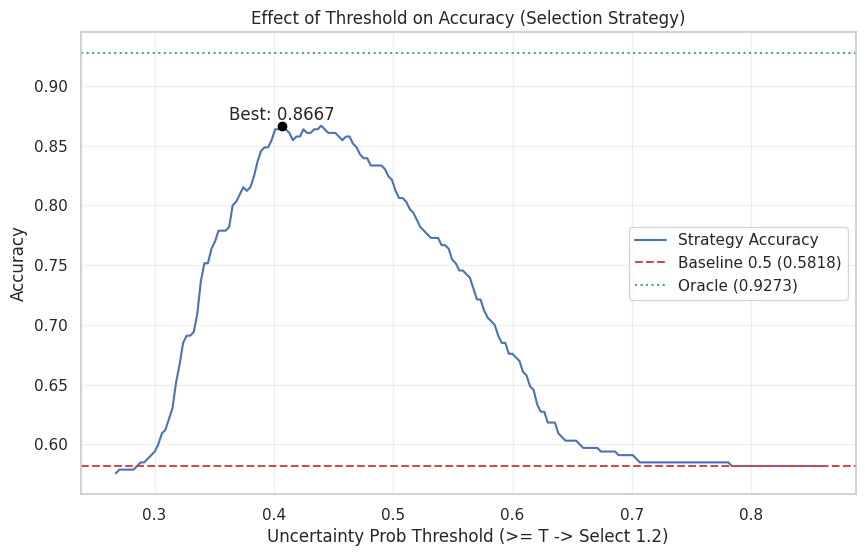

In [23]:
# 5. Threshold 최적화 및 시뮬레이션
# 전략: If uncertainty_prob >= threshold then '1.2' else '0.5'
# (Confidence가 높을 때 1.2를 시도하는 것이 유효한지 검증)

thresholds = np.linspace(df['uncertainty_prob'].min(), df['uncertainty_prob'].max(), 200)
accuracies = []

for th in thresholds:
    # 결정: 임계값보다 크면 1.2 선택, 아니면 0.5 선택
    decisions = df['uncertainty_prob'].apply(lambda x: '1.2' if x >= th else '0.5')
    
    # 검증: 결정된 Temperature가 그 행의 valid_choices에 들어있는지 확인
    # zip을 사용하여 효율적으로 순회
    correct_count = sum(1 for dec, valid in zip(decisions, df['valid_choices']) if dec in valid)
    acc = correct_count / len(df)
    accuracies.append(acc)

# 결과 분석
best_acc = max(accuracies)
best_th = thresholds[np.argmax(accuracies)]

print(f"\n=== Optimization Result ===")
print(f"Best Strategy Accuracy: {best_acc:.4f}")
print(f"Optimal Threshold: {best_th:.4f}")
print(f"Gain over Baseline (0.5): {(best_acc - acc_05) * 100:.2f}%p")

# 6. 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Strategy Accuracy')
plt.axhline(y=acc_05, color='r', linestyle='--', label=f'Baseline 0.5 ({acc_05:.4f})')
plt.axhline(y=acc_oracle, color='g', linestyle=':', label=f'Oracle ({acc_oracle:.4f})')

# 최적점 표시
plt.scatter([best_th], [best_acc], color='black', zorder=5)
plt.text(best_th, best_acc + 0.005, f'Best: {best_acc:.4f}', ha='center')

plt.title('Effect of Threshold on Accuracy (Selection Strategy)')
plt.xlabel('Uncertainty Prob Threshold (>= T -> Select 1.2)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

=== Baseline Analysis (KL) ===
Accuracy (Always 0.5): 0.5818
Oracle Accuracy: 0.9273

=== Optimization Result (KL Based) ===
Best Strategy Accuracy: 0.8667
Optimal Threshold: 0.0364
Gain over Baseline (0.5): 28.48%p


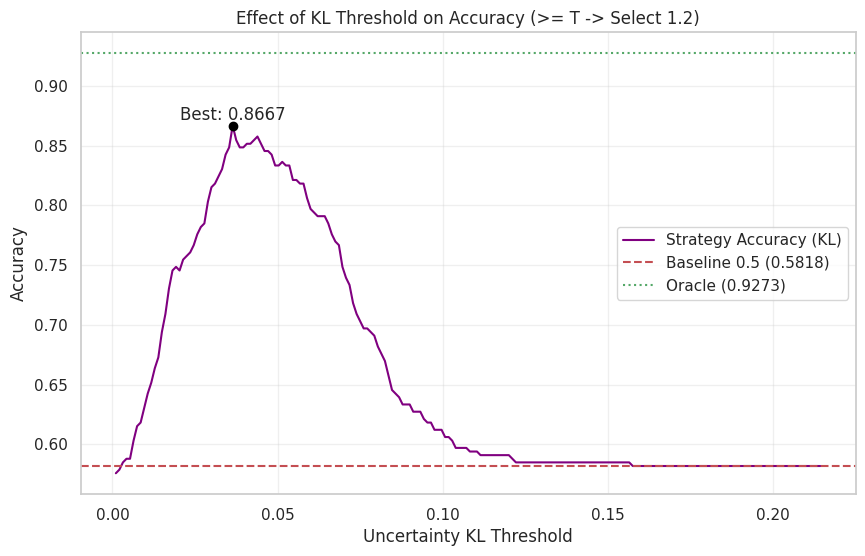

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리 (가정: df는 이미 로드됨)
# 이전 단계의 'valid_choices' 생성 로직이 이미 실행되었다고 가정합니다.
# 만약 없다면 아래 주석을 해제하여 실행하세요.
"""
df['is_correct_0.5'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('0.5')), axis=1)
df['is_correct_1.2'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('1.2')), axis=1)

def get_valid_choices(row):
    choices = []
    if row['is_correct_0.5']: choices.append('0.5')
    if row['is_correct_1.2']: choices.append('1.2')
    return choices

df['valid_choices'] = df.apply(get_valid_choices, axis=1)
"""

# 2. Baseline & Oracle Accuracy 계산 (비교용)
acc_05 = df['is_correct_0.5'].mean()
acc_12 = df['is_correct_1.2'].mean()
acc_oracle = df.apply(lambda row: len(row['valid_choices']) > 0, axis=1).mean()

print(f"=== Baseline Analysis (KL) ===")
print(f"Accuracy (Always 0.5): {acc_05:.4f}")
print(f"Oracle Accuracy: {acc_oracle:.4f}")

# 3. KL Threshold 최적화 및 시뮬레이션
# 전략: If uncertainty_kl >= threshold then '1.2' else '0.5'
# (불확실성이 높을 때 1.2를 시도하여 탈출을 시도하는 전략)

thresholds = np.linspace(df['uncertainty_kl'].min(), df['uncertainty_kl'].max(), 200)
accuracies = []

for th in thresholds:
    # 결정: KL이 임계값보다 크면 1.2 선택 (Uncertain -> Explore)
    # 만약 반대 전략(KL이 낮을 때 1.2)을 보고 싶다면 부등호를 바꾸면 됩니다.
    decisions = df['uncertainty_kl'].apply(lambda x: '1.2' if x >= th else '0.5')
    
    # 검증
    correct_count = sum(1 for dec, valid in zip(decisions, df['valid_choices']) if dec in valid)
    acc = correct_count / len(df)
    accuracies.append(acc)

# 결과 분석
best_acc = max(accuracies)
best_th = thresholds[np.argmax(accuracies)]

print(f"\n=== Optimization Result (KL Based) ===")
print(f"Best Strategy Accuracy: {best_acc:.4f}")
print(f"Optimal Threshold: {best_th:.4f}")
print(f"Gain over Baseline (0.5): {(best_acc - acc_05) * 100:.2f}%p")

# 4. 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Strategy Accuracy (KL)', color='purple')
plt.axhline(y=acc_05, color='r', linestyle='--', label=f'Baseline 0.5 ({acc_05:.4f})')
plt.axhline(y=acc_oracle, color='g', linestyle=':', label=f'Oracle ({acc_oracle:.4f})')

# 최적점 표시
plt.scatter([best_th], [best_acc], color='black', zorder=5)
plt.text(best_th, best_acc + 0.005, f'Best: {best_acc:.4f}', ha='center')

plt.title('Effect of KL Threshold on Accuracy (>= T -> Select 1.2)')
plt.xlabel('Uncertainty KL Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


=== Strategy Optimization Result ===
Baseline Accuracy (Always 0.5): 0.5818
Oracle Accuracy (Theoretical Max): 0.9394
Best Strategy Accuracy: 0.6879
Optimal Threshold (uncertainty_prob): 0.4405
Performance Gain: +10.61%p


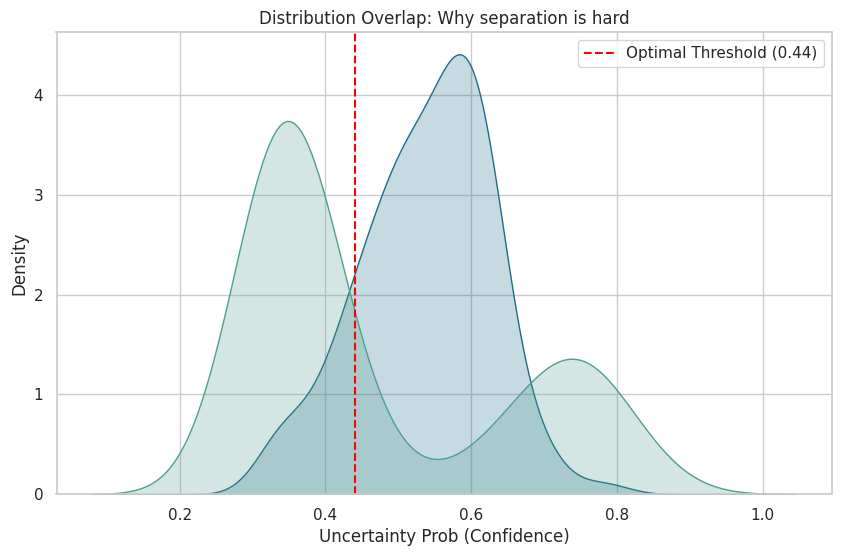

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 프레임이 있다고 가정 (df)
# best_choice가 'null'인 경우는 어차피 못 맞추므로 제외하고 분석하거나,
# 전략 수립 시에는 '0.5'를 선택하는 것으로 간주하여(Base strategy) Accuracy 계산에 포함해야 함.

def calculate_strategy_accuracy(df, threshold):
    """
    전략:
    If uncertainty_prob >= threshold:
        Select '1.2'
    Else:
        Select '0.5'
    
    비교: 실제 정답(best_choice)과 매칭 여부
    """
    # 전략에 따른 선택
    df['predicted_choice'] = df['uncertainty_prob'].apply(lambda x: '1.2' if x >= threshold else '0.5')
    
    # 정답 여부 판별
    # best_choice가 '1.0'인 경우도 있는데, 이는 전략에서 고려하지 못하므로 틀린 것으로 간주하거나 
    # 0.5/1.2 중 하나로 편입될 수 있는지 봐야 함. (여기서는 best_choice와 정확히 일치해야 정답으로 간주)
    correct_count = df[df['predicted_choice'] == df['best_choice']].shape[0]
    return correct_count / df.shape[0]

# 1. 최적의 Threshold 탐색
thresholds = np.linspace(df['uncertainty_prob'].min(), df['uncertainty_prob'].max(), 100)
accuracies = []

for th in thresholds:
    acc = calculate_strategy_accuracy(df.copy(), th)
    accuracies.append(acc)

best_acc = max(accuracies)
best_th = thresholds[np.argmax(accuracies)]

# 2. Baseline Accuracy (무조건 가장 많은 0.5만 선택했을 때)
baseline_acc = df[df['best_choice'] == '0.5'].shape[0] / df.shape[0]

print(f"=== Strategy Optimization Result ===")
print(f"Baseline Accuracy (Always 0.5): {baseline_acc:.4f}")
print(f"Oracle Accuracy (Theoretical Max): {upper_bound_acc:.4f}") # 이전 턴에서 계산됨
print(f"Best Strategy Accuracy: {best_acc:.4f}")
print(f"Optimal Threshold (uncertainty_prob): {best_th:.4f}")
print(f"Performance Gain: +{(best_acc - baseline_acc)*100:.2f}%p")

# 3. 시각화: 두 분포의 겹침 정도 확인
plt.figure(figsize=(10, 6))

# 0.5와 1.2만 필터링해서 시각화
subset = df[df['best_choice'].isin(['0.5', '1.2'])]

sns.kdeplot(data=subset, x='uncertainty_prob', hue='best_choice', fill=True, common_norm=False, palette="crest")
plt.axvline(best_th, color='red', linestyle='--', label=f'Optimal Threshold ({best_th:.2f})')

plt.title('Distribution Overlap: Why separation is hard')
plt.xlabel('Uncertainty Prob (Confidence)')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 기본 설정 및 데이터 전처리 (이전 단계와 동일)
# df는 이미 로드되어 있다고 가정합니다. (df = pd.DataFrame(json_data))
path = "output/results1.5_Controlled_Images_A_adapt_vis_research_1.0_1.0_fouroption_True.json"
with open(path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# 정답 여부 판별 함수
def check_is_correct(golden, gen):
    if not isinstance(gen, str): return False
    cond1 = (golden in gen) or (golden.lower() in gen.lower())
    cond2 = not (golden.lower() == 'on' and 'front' in gen.strip().lower())
    return cond1 and cond2

# 0.5와 1.2의 정답 여부 계산
df['is_correct_0.5'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('0.5')), axis=1)
df['is_correct_1.2'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('1.2')), axis=1)

# Valid Choices (정답인 Temperature 집합) 생성
def get_valid_choices(row):
    choices = []
    if row['is_correct_0.5']: choices.append('0.5')
    if row['is_correct_1.2']: choices.append('1.2')
    return choices

df['valid_choices'] = df.apply(get_valid_choices, axis=1)

# Baseline 계산
acc_05 = df['is_correct_0.5'].mean()
acc_oracle = df.apply(lambda row: len(row['valid_choices']) > 0, axis=1).mean()

print(f"=== Baseline Summary ===")
print(f"Baseline (Always 0.5): {acc_05:.4f}")
print(f"Oracle (Max Possible): {acc_oracle:.4f}")

# 2. 범용 분석 함수 정의
def analyze_metric(df, metric_col, strategy_type='high_uncertainty_triggers_1.2'):
    """
    metric_col: 분석할 컬럼명 (예: 'uncertainty_entropy')
    strategy_type: 
        - 'high_triggers_1.2': 값이 크면(>=T) 1.2 선택 (Entropy, Margin 등 불확실성 지표용)
        - 'low_triggers_1.2': 값이 작으면(<=T) 1.2 선택 (Prob 등 확신 지표용)
    """
    thresholds = np.linspace(df[metric_col].min(), df[metric_col].max(), 200)
    accuracies = []
    
    for th in thresholds:
        # 전략 결정
        if strategy_type == 'high_triggers_1.2':
            # 값이 크면(불확실하면) 1.2 시도
            decisions = df[metric_col].apply(lambda x: '1.2' if x >= th else '0.5')
        else:
            # 값이 작으면(불확실하면) 1.2 시도 (Confidence가 낮을 때)
            decisions = df[metric_col].apply(lambda x: '1.2' if x <= th else '0.5')
            
        # 검증
        correct_count = sum(1 for dec, valid in zip(decisions, df['valid_choices']) if dec in valid)
        accuracies.append(correct_count / len(df))
    
    best_acc = max(accuracies)
    best_th = thresholds[np.argmax(accuracies)]
    
    return best_acc, best_th, thresholds, accuracies




=== Baseline Summary ===
Baseline (Always 0.5): 0.5818
Oracle (Max Possible): 0.9273



=== Optimization Results ===
[Prob] Best: 0.8667 (Th: 0.4154) | Gain: 28.48%p
[Entropy] Best: 0.8636 (Th: 0.9015) | Gain: 28.18%p
[Margin] Best: 0.8485 (Th: 0.8278) | Gain: 26.67%p


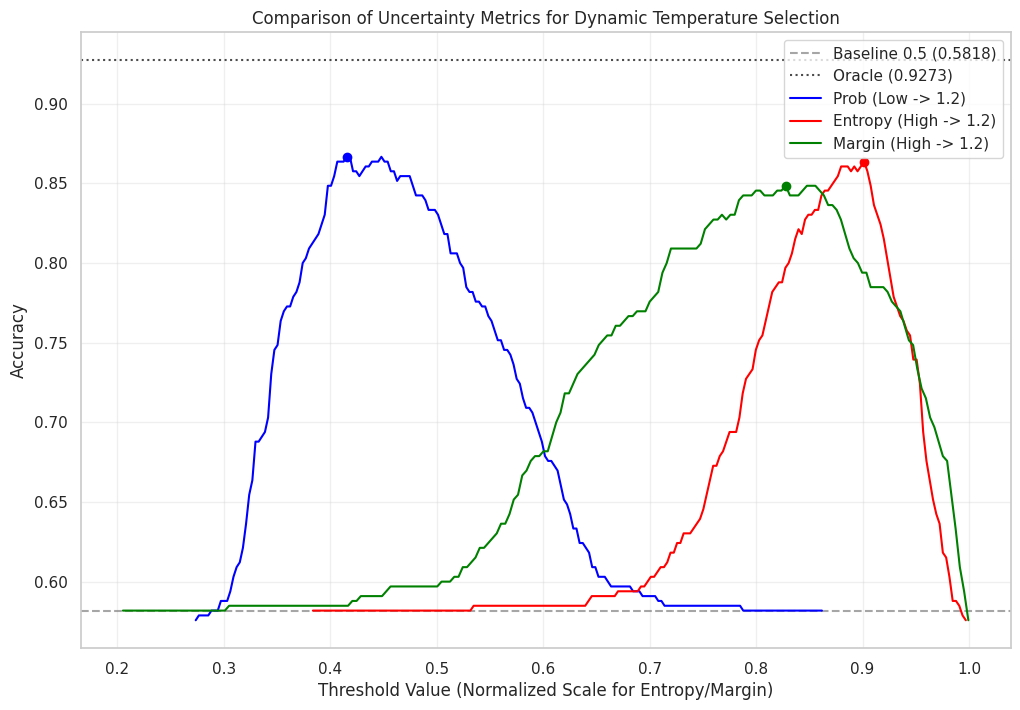

In [28]:
# 3. 각 지표별 분석 실행

# (1) Prob (Confidence): 값이 낮으면 불확실 -> 1.2 선택
best_acc_prob, th_prob, x_prob, y_prob = analyze_metric(df, 'uncertainty_prob', 'high_triggers_1.2')

# (2) Entropy: 값이 높으면 불확실 -> 1.2 선택
best_acc_ent, th_ent, x_ent, y_ent = analyze_metric(df, 'uncertainty_entropy', 'low_triggers_1.2')

# (3) Margin (1 - Gap): 값이 높으면 불확실 -> 1.2 선택
# (앞서 구현된 get_uncertainty에서 margin은 1 - (Top1-Top2)로 저장되었다고 가정)
best_acc_mar, th_mar, x_mar, y_mar = analyze_metric(df, 'uncertainty_margin', 'low_triggers_1.2')

print(f"\n=== Optimization Results ===")
print(f"[Prob] Best: {best_acc_prob:.4f} (Th: {th_prob:.4f}) | Gain: {(best_acc_prob - acc_05)*100:.2f}%p")
print(f"[Entropy] Best: {best_acc_ent:.4f} (Th: {th_ent:.4f}) | Gain: {(best_acc_ent - acc_05)*100:.2f}%p")
print(f"[Margin] Best: {best_acc_mar:.4f} (Th: {th_mar:.4f}) | Gain: {(best_acc_mar - acc_05)*100:.2f}%p")

# 4. 시각화 (통합 그래프)
plt.figure(figsize=(12, 8))

# Baseline & Oracle
plt.axhline(y=acc_05, color='gray', linestyle='--', label=f'Baseline 0.5 ({acc_05:.4f})', alpha=0.7)
plt.axhline(y=acc_oracle, color='black', linestyle=':', label=f'Oracle ({acc_oracle:.4f})', alpha=0.7)

# Metrics Plot
plt.plot(x_prob, y_prob, label='Prob (Low -> 1.2)', color='blue')
plt.plot(x_ent, y_ent, label='Entropy (High -> 1.2)', color='red')
plt.plot(x_mar, y_mar, label='Margin (High -> 1.2)', color='green')

# Best Points
plt.scatter([th_prob], [best_acc_prob], color='blue', zorder=5)
plt.scatter([th_ent], [best_acc_ent], color='red', zorder=5)
plt.scatter([th_mar], [best_acc_mar], color='green', zorder=5)

plt.title('Comparison of Uncertainty Metrics for Dynamic Temperature Selection')
plt.xlabel('Threshold Value (Normalized Scale for Entropy/Margin)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [1]:
!bash ex1.sh

/venv/env1/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:08<00:00,  2.99s/it]
Some weights of LlavaForConditionalGenerationScal were not initialized from the model checkpoint at llava-hf/llava-1.5-7b-hf and are newly initialized: ['language_model.model.layers.0.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.1.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.10.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.11.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.12.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.13.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.14.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.15.self